In [1]:
from pipeline import (univariate_data_analysis, load_data, split_data, optimize_model, #compare_models,
split_univariate_sequence, objective, time_series_forecasting, prepare_data_for_optimization, create_optuna_model)
import pandas as pd

2025-04-02 09:47:56.275771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743608876.306837 1631469 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743608876.316090 1631469 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-02 09:47:56.347833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# First we load the data

In [2]:
df_filtered, df_info_filtered = load_data()

Info Filtered:
       M4id category  Frequency  Horizon      SP    StartingDate
99623   H38    Other         24       48  Hourly  01-07-15 12:00
99649   H64    Other         24       48  Hourly  01-07-15 12:00
99813  H228    Other         24       48  Hourly  15-05-10 12:00
99860  H275    Other         24       48  Hourly  02-01-10 12:00
99989  H404    Other         24       48  Hourly  06-01-17 12:00

Filtered Data (First Rows):
V1 Step  H404  H275     H64  H228     H38
0    V2  27.0  15.3  2777.0  12.4  3648.0
1    V3  22.0  15.0  2886.0  11.7  3658.0
2    V4  25.0  14.7  2811.0  11.1  3608.0
3    V5  25.0  14.4  2648.0  10.7  3493.0
4    V6  14.0  14.3  2618.0  10.3  3374.0


In [3]:
# Here we add the indexes of time based on the metadata
def index_date(ts):
    starting_date = df_info_filtered[df_info_filtered['M4id'] == ts]['StartingDate'].iloc[0]
    date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')
    df_filtered[ts].index = date_range
    return df_filtered[ts].dropna()

ts = index_date('H38')

# Then we explore the series, with distribution, the ACF, PACF, moving avg, decomposition and descriptive statistics

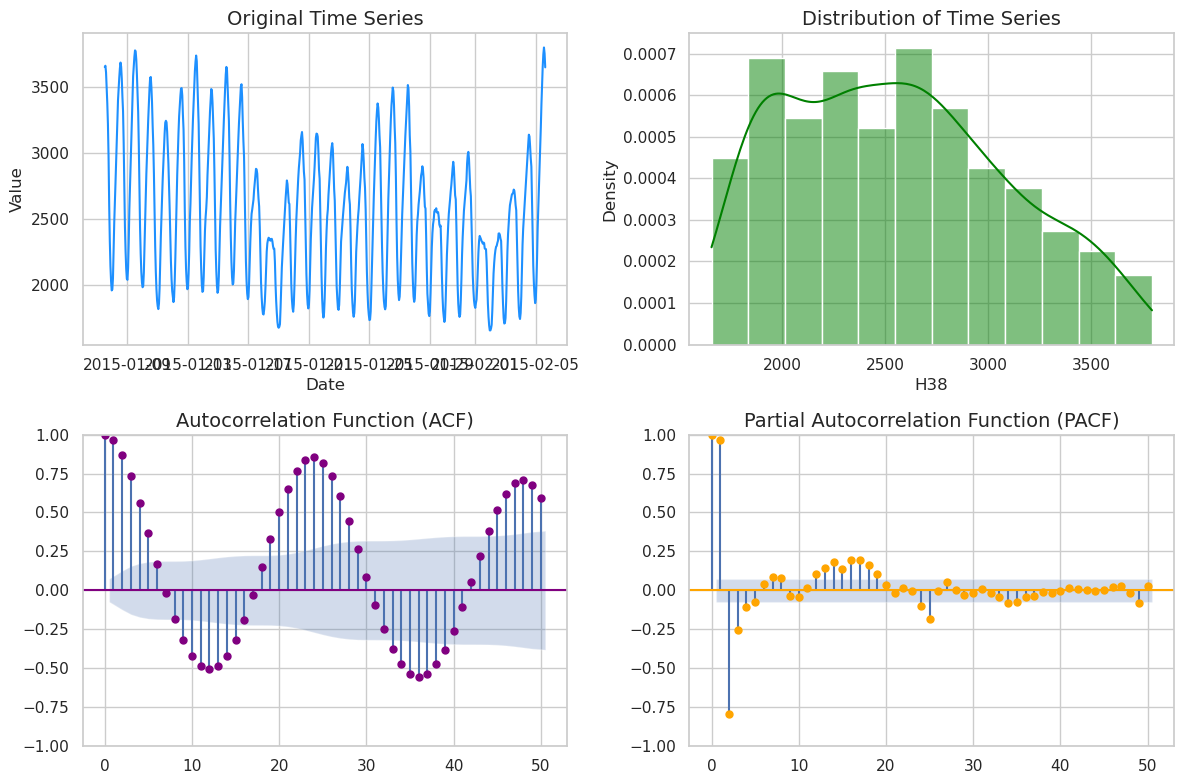

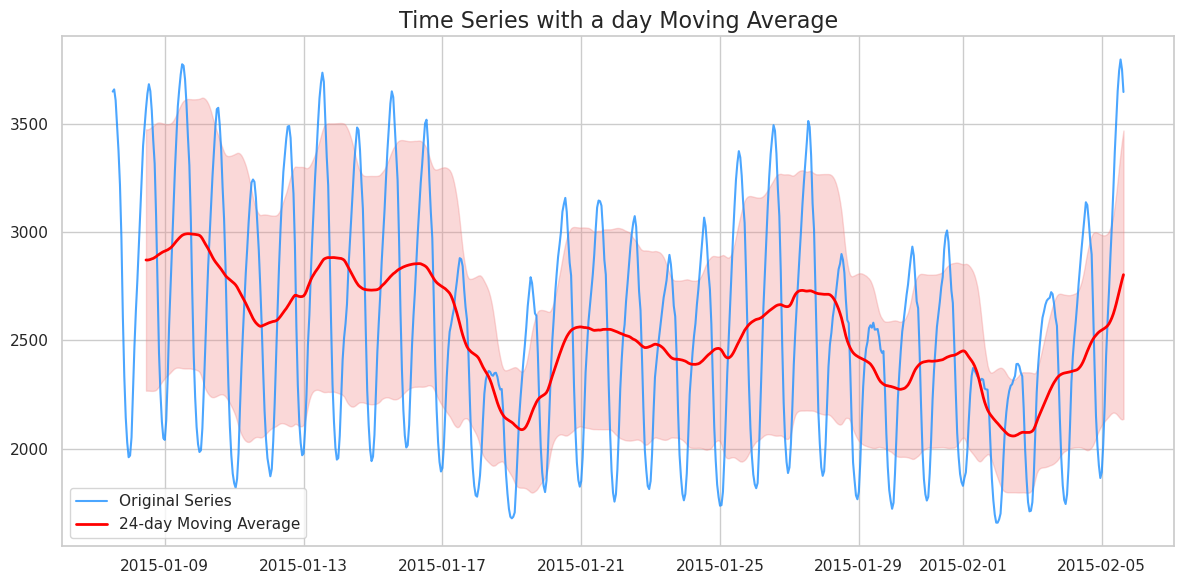

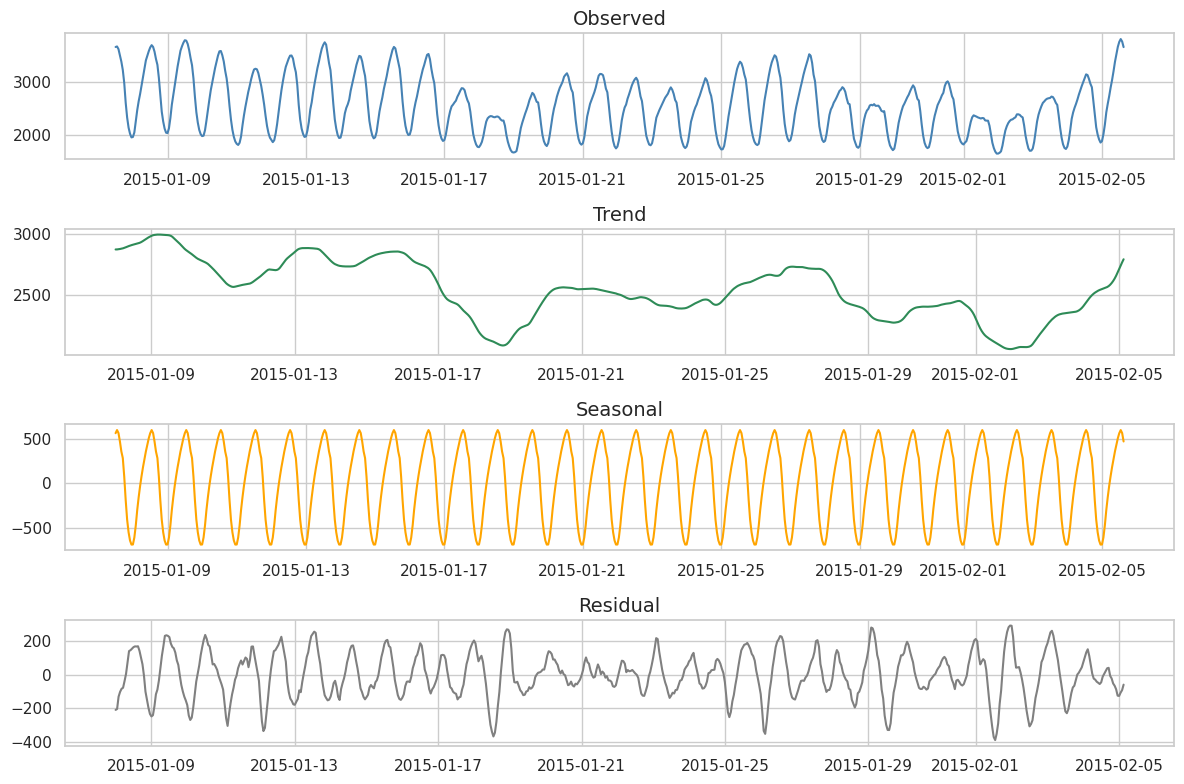

Descriptive Statistics:
count     700.000000
mean     2553.945714
std       534.399763
min      1658.000000
25%      2097.000000
50%      2533.500000
75%      2930.500000
max      3796.000000
Name: H38, dtype: float64

Shapiro-Wilk Test p-value: 1.3084320953093975e-11
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -1.516793800707267
p-value: 0.5251879337748036
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [4]:
univariate_data_analysis(ts)

- **Distribution:**  
  The histogram appears slightly **skewed**, with a **mean around 2553**. This behavior suggests **different states**, as observed in the time series plot. The **descriptive statistics** confirm this. Additionally, the **Shapiro-Wilk test** confirms the **lack of normality** in this series.  

- **Autocorrelation:**  
  A clear pattern emerges **every 24 hours**, reinforcing the fact that the series exhibits **daily seasonality**.  

- **Partial Autocorrelation:**  
  Significant spikes at the **first and second lags** indicate a **strong autoregressive component**. This means that **previous observations** have a **major impact** on the next ones.  

- **ADF Test:**  
  The test suggests that the series is **non-stationary**, aligning with the **seasonal patterns** previously observed.  


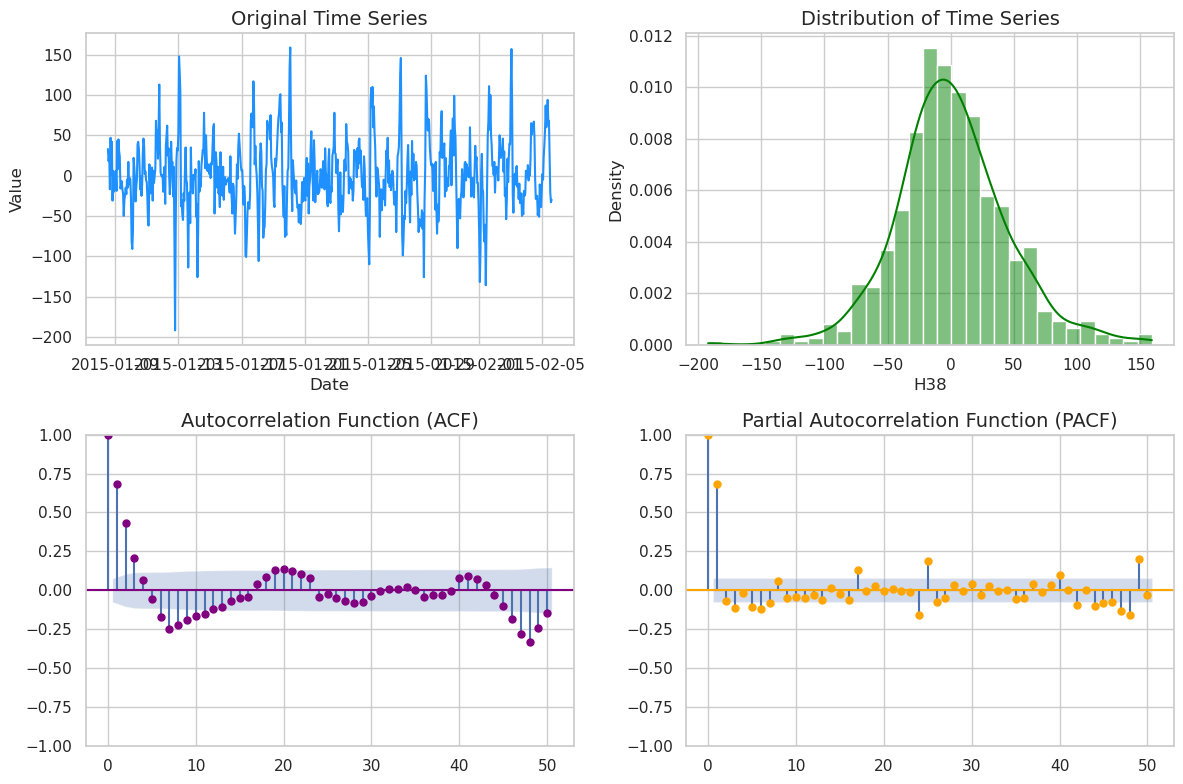

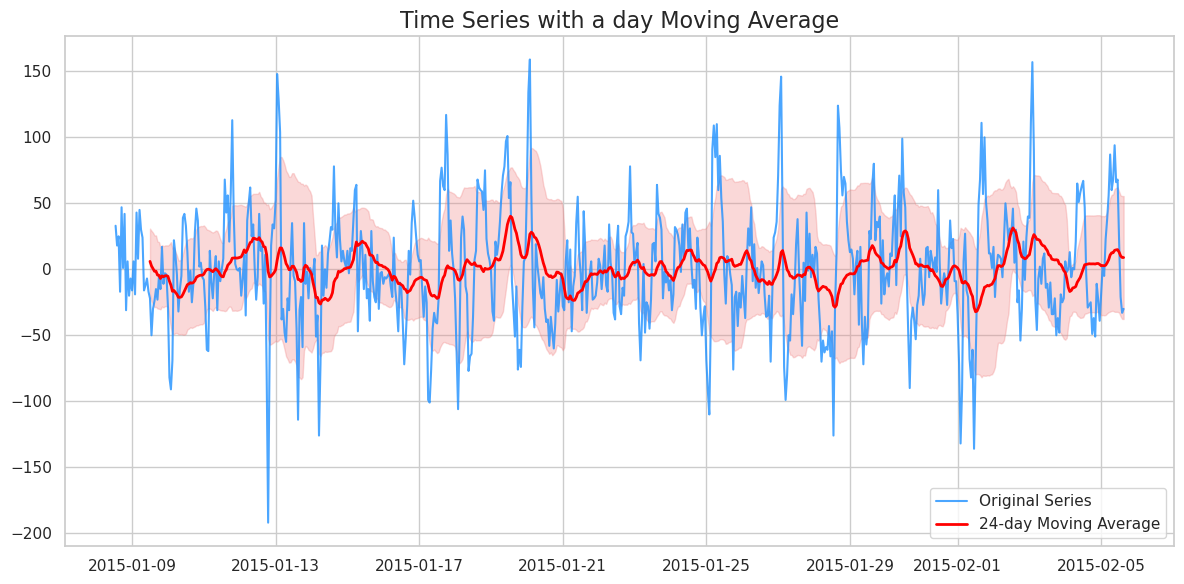

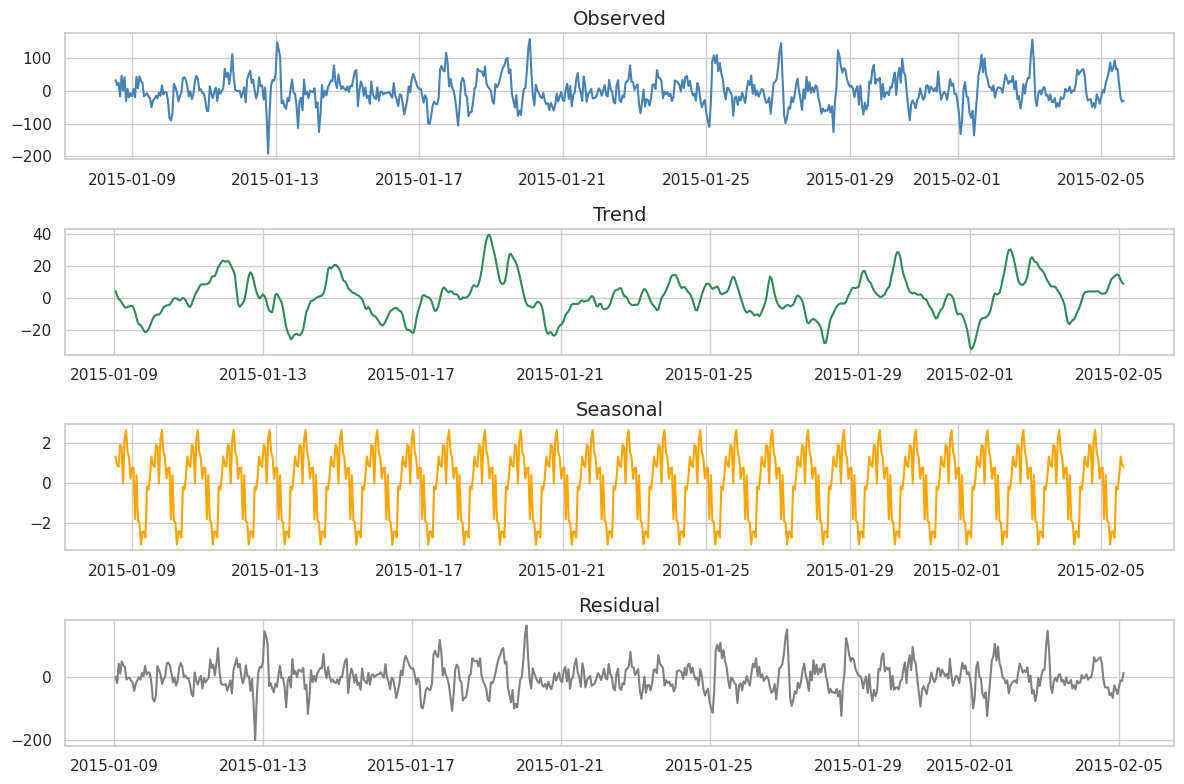

Descriptive Statistics:
count    675.000000
mean       0.896296
std       44.052955
min     -192.000000
25%      -25.000000
50%       -2.000000
75%       25.000000
max      159.000000
Name: H38, dtype: float64

Shapiro-Wilk Test p-value: 4.911736368740094e-07
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -6.826294022280299
p-value: 1.944049580844654e-09
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [17]:
univariate_data_analysis(ts.diff(24).diff().dropna())

We can analyze this as if we were going to apply **SARIMA**.  

After performing a **daily difference (diff by 24 lags)** and a **regular difference**, we remove the seasonal pattern. Now, the **distribution** (or non-seasonal component) appears **normal**, which is beneficial for **SARIMA modeling**.  

Key observations:  
- The **ACF** shows **three important spikes**, indicating **short-term correlations**.  
- The **Shapiro-Wilk test** reports a **small p-value**, suggesting that the data is **not actually normal**, despite appearing so. This may be due to **outliers**.  
- The **ADF test** confirms that the series is **stationary**.  


# Then We Split the Data and Model  

The `time_series_forecasting` function applies a **Min-Max scaling transformation** to help the model converge faster. It then:  

1. **Creates daily sequences**  
2. **Reshapes the data** for each specific architecture  
3. **Trains 12 different architectures** (3 per model) with **early stopping** for 200 epochs  
4. **Selects the best model** based on the lowest **MAE**  
5. **Plots its predictions** and comparisons with the test data  

This ensures we find the most effective model for the given time series data.  


Train: 441, Validation: 105, Test: 106


C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\s

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MLP Model 1 MAE: 39.4025908679497
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MLP Model 2 MAE: 118.52236566310974
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MLP Model 3 MAE: 28.404122701505337
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
CNN Model 1 MAE: 32.698038240758386
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
CNN Model 2 MAE: 95.02577172256096
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
CNN Model 3 MAE: 131.34444669397865
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
LSTM Model 1 MAE: 43.10056063024009
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
LSTM Model 2 MAE: 51.743978360804114
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
LSTM Model 3 MAE: 76.84570461366233
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
CNN-LSTM Model 1 MAE: 37.968891422923015
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
CNN-LSTM Model 2 MAE: 96.85127072217988
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
CNN-LSTM Model 3 MAE: 43.011148592320886

Best Model: MLP Model 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/st

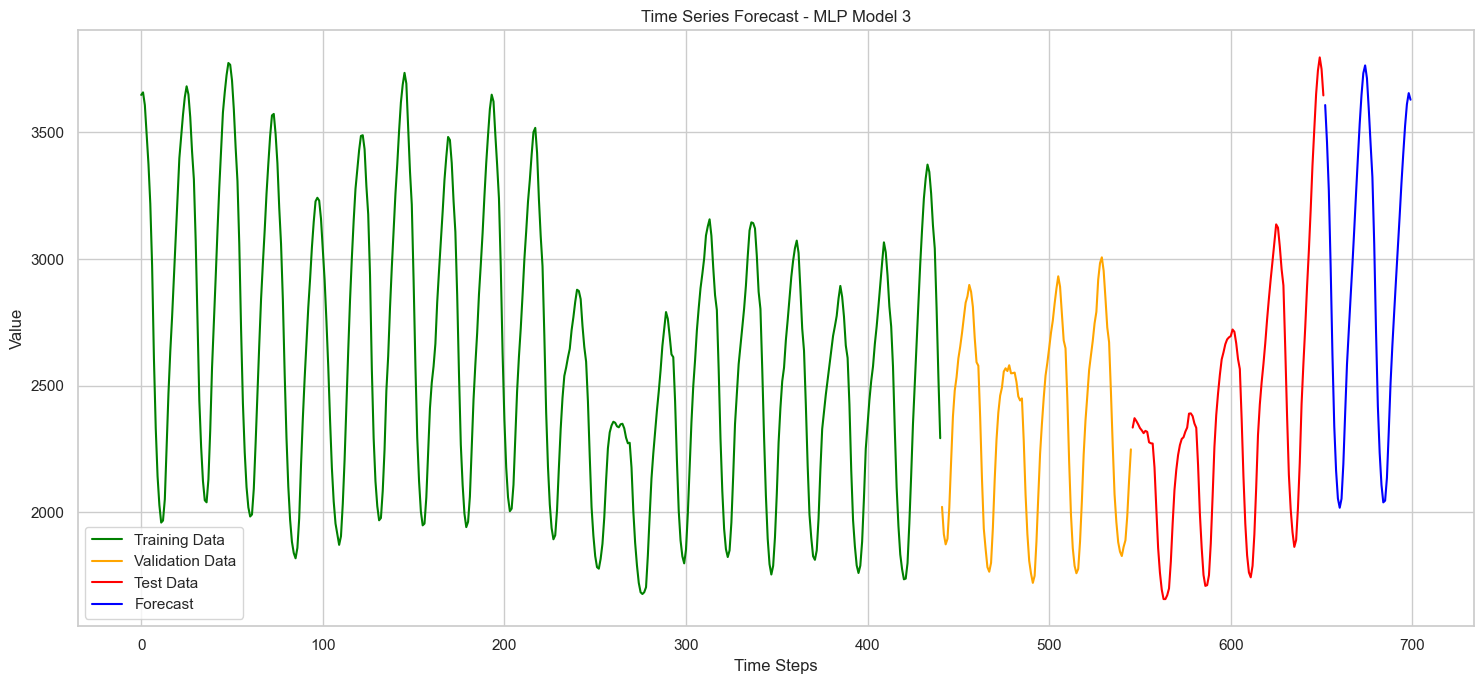

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


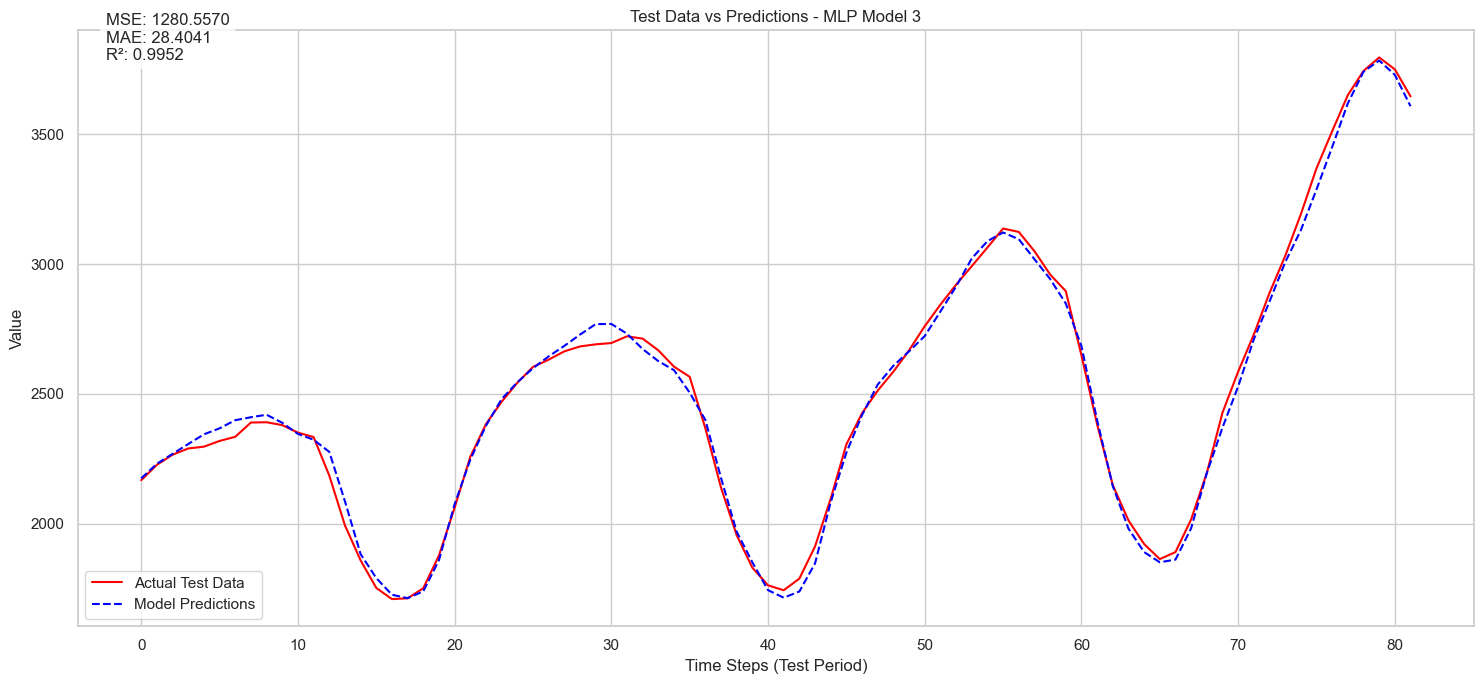


Model Performance Comparison:
      Model Type  Mean Absolute Error
     MLP Model 3            28.404123
     CNN Model 1            32.698038
CNN-LSTM Model 1            37.968891
     MLP Model 1            39.402591
CNN-LSTM Model 3            43.011149
    LSTM Model 1            43.100561
    LSTM Model 2            51.743978
    LSTM Model 3            76.845705
     CNN Model 2            95.025772
CNN-LSTM Model 2            96.851271
     MLP Model 2           118.522366
     CNN Model 3           131.344447


In [13]:
train_data, val_data, test_data = split_data(ts)
best_model = time_series_forecasting(train_data, val_data, test_data)

After changing some hyperparameters and layers and running the experiments again, I obtained the **best model** with a **28.4 MAE**.  

The best model was an **MLP** with:  
- **4 dense layers**  
- **Neuron counts:** 256 → 128 → 64 → 32  
- **Activation function:** ReLU  


In [14]:
best_model['best_model'].summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

Here we can see its arch

# Optuna

After that, we select the model that gave the best results and optimize it with **Optuna** for:  
- **Learning rate**  
- **Activation functions**  
- **Number of layers**  
- **Number of units per layer**  
- **Optimizer**  

The function is designed to **adapt** and tune the best model architecture **regardless of its type**, as different models can perform better depending on the series. Our goal is to achieve the **optimal performance** possible.  

The experiment runs for **200 trials**, then the results are **de-scaled** and plotted against the **test set**, allowing us to compare with the previous model.  


[I 2025-04-02 10:25:30,156] A new study created in memory with name: no-name-1b692df1-3c8b-4e14-aef3-672e68d67253


Train: 441, Validation: 105, Test: 106


/home/pepechuy/Downloads/School/Sexto Semestre/nolineales/Examen2/Examen2NL/pipeline.py:690: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
2025-04-02 10:25:30.164335: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-04-02 10:25:35,532] Trial 0 finished with value: 0.043274521827697754 and parameters: {'optimizer'

Best MLP Model Optimization Results:
  Number of trials: 200
  Best trial value (MAE): 0.015093838796019554
  Best hyperparameters:
    optimizer: adam
    learning_rate: 0.005665018689440779
    activation: tanh
    n_layers: 2
    neurons_0: 217
    neurons_1: 107
    dropout_1: 0.030058164869637208
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━

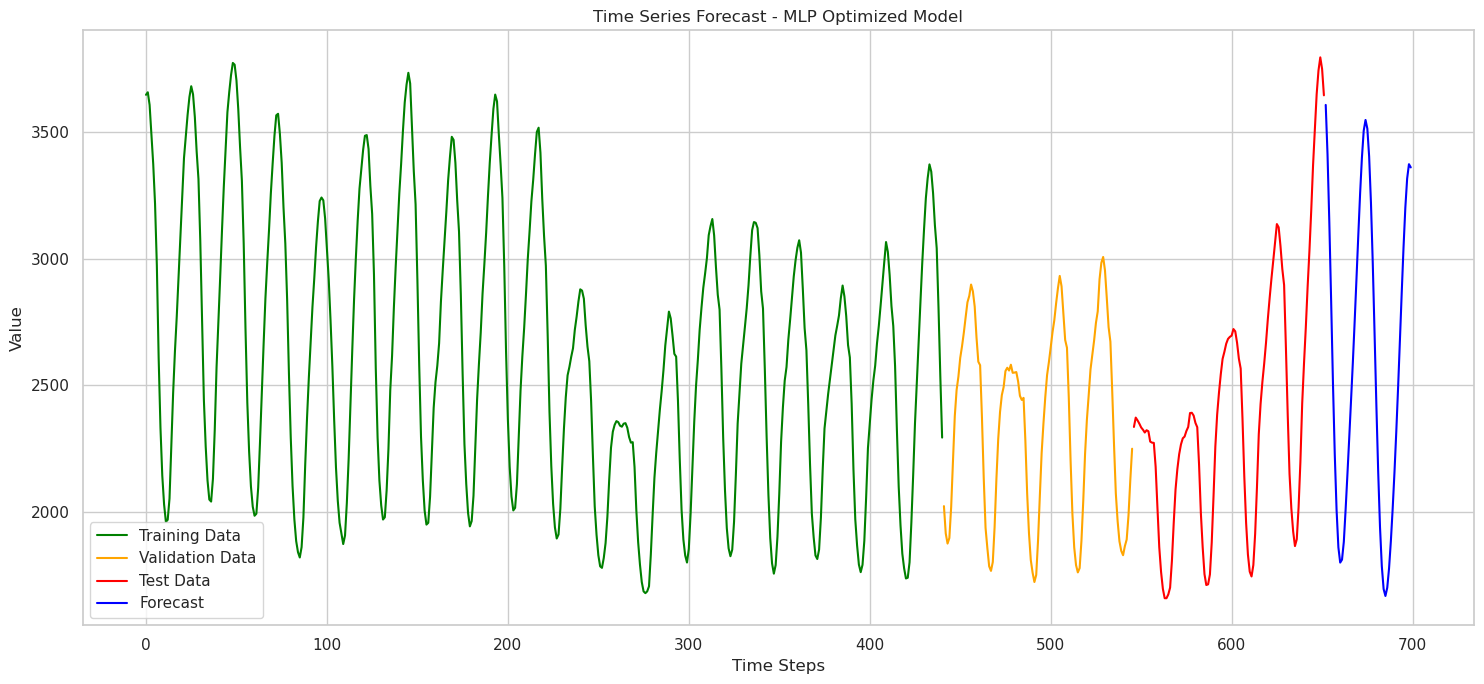


Test Data Prediction Analysis:


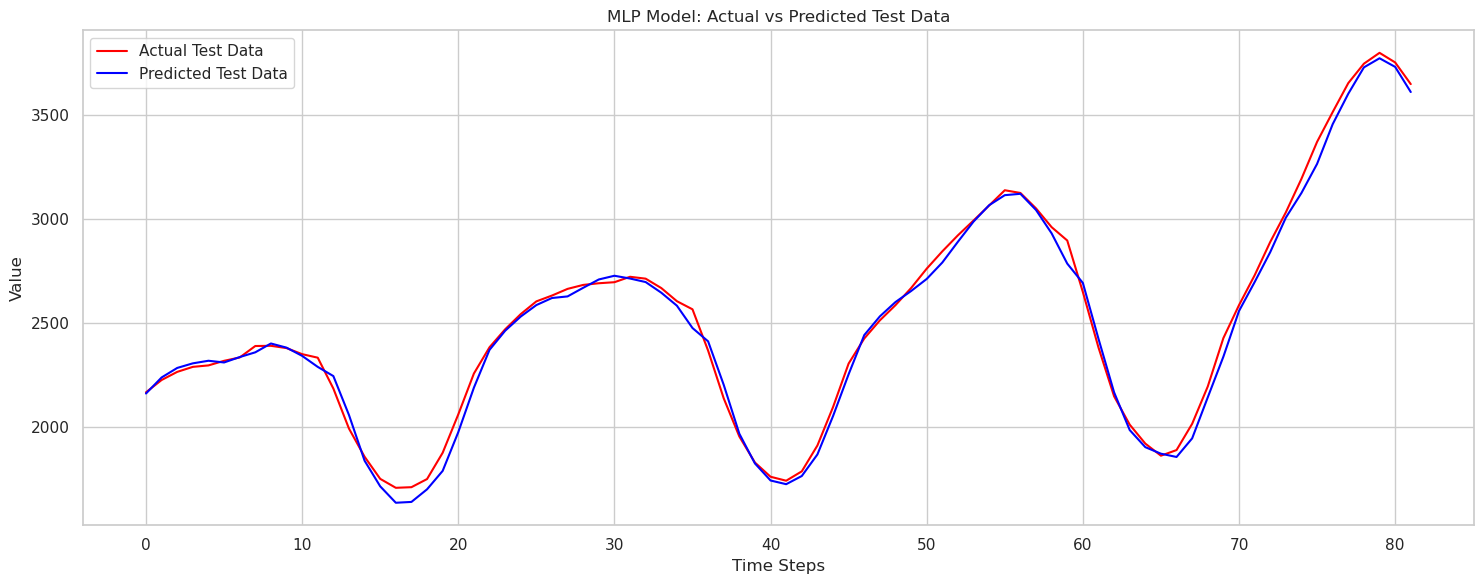


Model Performance Metrics:
Mean Absolute Error (MAE): 33.34074290205792
Mean Squared Error (MSE): 1766.6755694870535


In [19]:
result = optimize_model(train_data, val_data, test_data, n_steps=24, model_type='mlp', n_trials=200)
best_model = result['best_model']
best_params = result['best_params']
scaler = result['scaler']

## After 200 Experiments, We Obtained the Best Architecture

### Best MLP Model Optimization Results:

- **Number of trials:** 200  
- **Best trial value (MAE):** 0.015093838796019554  
- **Best hyperparameters:**
  - **Optimizer:** adam  
  - **Learning rate:** 0.005665018689440779  
  - **Activation:** tanh  
  - **Number of layers:** 2  
  - **Neurons per layer:**
    - **Layer 0:** 217  
    - **Layer 1:** 107  
  - **Dropout (Layer 1):** 0.030058164869637208  

We achieved a **33.3 MAE**, which indicates a strong model. However, in this scenario, it does not outperform the last manually tuned model.


However, the **Optuna-optimized model** reduced the **number of layers** and changed some **activation functions**. This resulted in a **simpler model**.  

If our priority is **speed over performance**, we might choose to **sacrifice a little accuracy** in favor of faster computations.  
